## Preprocessing Data



In [1]:
import pandas as pd 
import numpy as np 

raw = pd.read_csv("D:\\Programming\\Python_code\\PrinciplesOfDS_Course\\Labs\\Data\\insurance.csv")
print(raw.info())
print(raw.isna().sum()/raw.shape[0])

#separate out categorical features from numeric
categorical = raw.drop(columns=["age", "bmi", "charges", "children"])
print(categorical.info())

numeric = raw.drop(columns=["sex", "smoker", "region"])
print(numeric.info())

# checking object locations in memory:
print("Displaying IDs: \n\n\n",id(raw), id(categorical), id(numeric))

# anther way to check if two objects are the same in memory: 
print("\n",raw is categorical, raw is numeric, numeric is categorical, "\n")

# convert categorical features to numeric 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

lenc = LabelEncoder()
categorical = categorical.apply(lenc.fit_transform) # convert all categoricals to numeric using .apply()
print(categorical.info())

# Inspect unique values: 
#print(categorical.apply(unique)) # surprised I cannot use this syntax... I guess because the DF lacks the method.. maybe only series can have unique used on them? weird. 

print('Col 1:',categorical.iloc[:,0].unique(), 'Col 2:',categorical.iloc[:,1].unique(),'Col 3:',categorical.iloc[:,2].unique())
#Col 1: [0 1] Col 2: [1 0] Col 3: [3 2 1 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     1338 non-null   object
 1   smoker  1338 non-null   object
 2   region  1338 non-null   object
dtypes: object(3)
memory usage: 31.5+ KB
None
<class 'pandas.c

In [2]:
# Recombining DFs, going to test the model on both non-normalized binary cols as well as normalized binary cols. 

#preProc = pd.concat([numeric,categorical], ignore_index=True, sort=False) # .append is deprecated.
#print(preProc.info()) # important to note here, is whether or not any values would be shifted around, corrupting the data by mixing and matching values from different observations
# so using concat actually added the new columns as new rows and didn't attmept to bind them together col by col.  

preProc = numeric.join(categorical) # .join() works for just smashing two DFs together by index. 
print("Join version, uses indices as the key to join the two DFs from: \n", preProc.info())
# not sure why, but the info() table prints before everything else.. which is honestly confusing. Will have to remember this abnormal behavior. 

x_mean_pd = preProc.mean() # I want to see what difference comes of using the DF method for mean vs a numpy method. 
x_std_pd = preProc.std()
x_mean = np.mean(preProc, axis=0)
x_std = np.std(preProc)

print("\nMethod differences. pandas mean output and type:\n", x_mean_pd, type(x_mean_pd), "\n\nnumpy mean and output type:\n", x_mean, type(x_mean))
# all the same. So it is safe to not use the numpy method I suppose which is nice as the syntax is cleaner for the pandas version

print("\nMethod differences. pandas std output and type:\n", x_std_pd, type(x_std_pd), "\n\nnumpy std and output type:\n", x_std, type(x_std))
# again no differences. So I think I will stick with the simpler syntax until I have reason to move on 

# Normalizing w/ Z-score standardization
preProc = (preProc-x_mean)/x_std

# creating non-normalized binary feature matrix
preProcBinary = preProc.copy()
preProcBinary['sex'] = categorical['sex']
preProcBinary['smoker'] = categorical['smoker']

print(preProc.head())
print(preProcBinary.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   charges   1338 non-null   float64
 4   sex       1338 non-null   int32  
 5   smoker    1338 non-null   int32  
 6   region    1338 non-null   int32  
dtypes: float64(2), int32(3), int64(2)
memory usage: 57.6 KB
Join version, uses indices as the key to join the two DFs from: 
 None

Method differences. pandas mean output and type:
 age            39.207025
bmi            30.663397
children        1.094918
charges     13270.422265
sex             0.505232
smoker          0.204783
region          1.515695
dtype: float64 <class 'pandas.core.series.Series'> 

numpy mean and output type:
 age            39.207025
bmi            30.663397
children        1.094918
charges     13270.422265
sex

## Splitting Data into Training and Testing sets


In [3]:
# predicting cost, so dropping from feature matrix 
from sklearn.model_selection import train_test_split

feat = preProc.drop(columns="charges")
featBin = preProcBinary.drop(columns="charges")

charges = preProc['charges']
chargesBin = preProcBinary['charges']

# given my data is already standardized I don't think this normalization is necessary... 
# but I suppose I don't know how if effects things. Maybe can run code with and without this line to learn
charges = charges / charges.max()
chargesBin = chargesBin / chargesBin.max()

Xtrain, Xtest, yTrain, yTest = train_test_split(feat, charges, test_size=0.2, random_state=1)
XtrainBin, XtestBin, yTrainBin, yTestBin = train_test_split(featBin, chargesBin, test_size=0.2, random_state=1)

print(Xtrain.shape, "\n", Xtest.shape)



(1070, 6) 
 (268, 6)


## Training Linear Regression Model 


In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

lr = LinearRegression()
lrBin = LinearRegression()
lr.fit(Xtrain, yTrain)
lrBin.fit(XtrainBin, yTrainBin)

print("Bias and Coefficient: ", str(lr.intercept_), str(lr.coef_)) 
print("Bias and Coefficient for Binary set: ", str(lrBin.intercept_), str(lrBin.coef_)) # bias is notably lower at -0.09411506075534107
# coefficients are different on the binary values as well 

yTrainPred = lr.predict(Xtrain)
yTrainPredBin = lrBin.predict(XtrainBin)

mae = mean_absolute_error(yTrainPred, yTrain)
maeBin = mean_absolute_error(yTrainPredBin, yTrainBin)
mse = mean_squared_error(yTrainPred, yTrain)
mseBin = mean_squared_error(yTrainPredBin, yTrainBin)
rmse = np.sqrt(mse)
rmseBin = np.sqrt(mseBin)

print('prediction for training set:')
print('MAE is: {}'.format(mae))
print('MSE is: {}'.format(mse))
print('RMSE is: {}'.format(rmse))

print('prediction for Binary training set:')
print('MAEBin is: {}'.format(maeBin))
print('MSEBin is: {}'.format(mseBin))
print('RMSEBin is: {}'.format(rmseBin))
# predictions are totally equal despite different normalization here 


Bias and Coefficient:  -0.00018156234829435063 [ 0.07175749  0.03803399  0.00983693 -0.00241884  0.18992077 -0.00723105]
Bias and Coefficient for Binary set:  -0.09411506075534107 [ 0.07175749  0.03803399  0.00983693 -0.00483794  0.4706331  -0.00723105]
prediction for training set:
MAE is: 0.08258086203594743
MSE is: 0.014436963667139062
RMSE is: 0.12015391657011877
prediction for Binary training set:
MAEBin is: 0.08258086203594743
MSEBin is: 0.014436963667139062
RMSEBin is: 0.12015391657011877


## Evaluating the Lin Regression Model:


prediction for training set:
MAE is: 0.08031916523248306
MSE is: 0.013912618660778234
RMSE is: 0.11795176412745269
prediction for Binary training set:
MAEBin is: 0.08031916523248307
MSEBin is: 0.013912618660778234
RMSEBin is: 0.11795176412745269


C:\Users\Tanner_N\AppData\Local\Temp\ipykernel_16172\778208551.py:29: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  bars1 = axes.bar(x-width/2, yTest[0:10], width, label='Ground Truth')


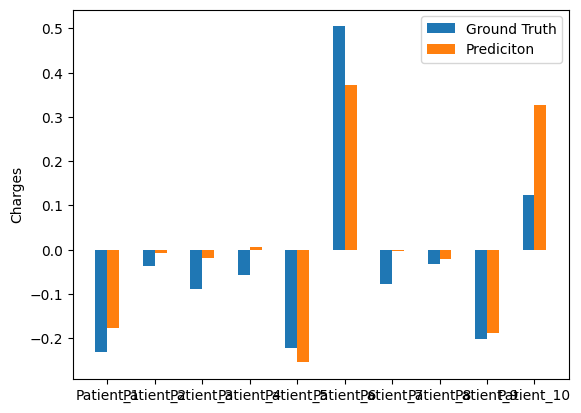

In [5]:
import matplotlib.pyplot as plt

yTestPred = lr.predict(Xtest)
yTestPredBin = lrBin.predict(XtestBin)

mae = mean_absolute_error(yTestPred, yTest)
maeBin = mean_absolute_error(yTestPredBin, yTestBin)
mse = mean_squared_error(yTestPred, yTest)
mseBin = mean_squared_error(yTestPredBin, yTestBin)
rmse = np.sqrt(mse)
rmseBin = np.sqrt(mseBin)

print('prediction for training set:')
print('MAE is: {}'.format(mae))
print('MSE is: {}'.format(mse))
print('RMSE is: {}'.format(rmse))

print('prediction for Binary training set:')
print('MAEBin is: {}'.format(maeBin))
print('MSEBin is: {}'.format(mseBin))
print('RMSEBin is: {}'.format(rmseBin))

# We have 268 rows, so visualizing only a handful of results doesn't seem meaningful. 
labels = ['Patient_1','Patient_2','Patient_3','Patient_4','Patient_5','Patient_6','Patient_7','Patient_8','Patient_9','Patient_10']
x = np.arange(len(labels))
width = .25

figure, axes = plt.subplots()
bars1 = axes.bar(x-width/2, yTest[0:10], width, label='Ground Truth')
bars2 = axes.bar(x+width/2, yTestPred[0:10], width, label='Prediciton')

axes.set_ylabel('Charges')
axes.set_xticks(x)
axes.set_xticklabels(labels)
axes.legend()

plt.show()
# my plot is looking pretty weird for a few reasons. Too many objects with too long of names for the labels to look good... 
# also the normalization that I did resulted in negative values which.. maybe is meaningful for the ability to have a good model, but visually/logically isn't helpful for understanding the outcomes. I don't really know what it means that some patients have charges which are negative 

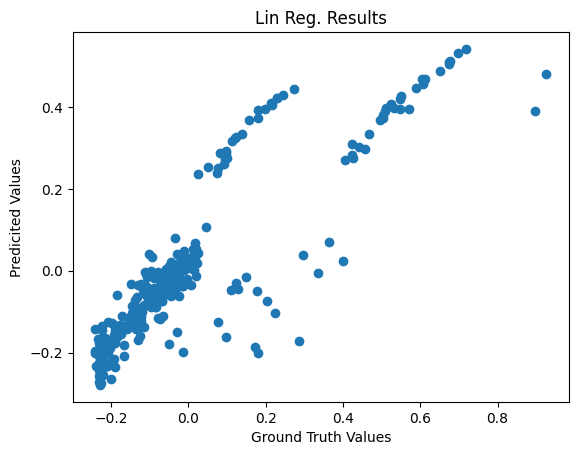

In [6]:
# making scatter plot for visualization: 

plt.scatter(yTest, yTestPred)
plt.xlabel("Ground Truth Values")
plt.ylabel("Predicited Values")
plt.title("Lin Reg. Results")
plt.show()

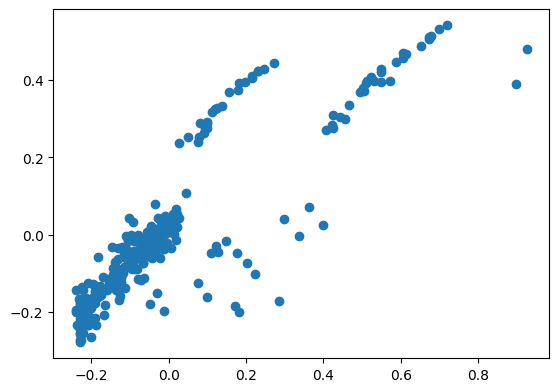

In [7]:
fig, ax = plt.subplots()
scatter = ax.scatter(yTest, yTestPred)
ax.set_aspect('equal') # Chat GPT is lying or messed up... this isn't working for setting the scale of x and y equal 
plt.show()

## Min Max Scaled Data Work


In [8]:
# Diff preprocessing of data for more understandable model evaluation 
from sklearn.preprocessing import MinMaxScaler

mmScaler = MinMaxScaler()
X_3 = numeric.join(categorical)
medicalFeatures = X_3.drop(columns='charges').values
chrgVal = X_3['charges'].values


Xtrmm, Xtsmm, ytrmm, ytsmm, = train_test_split(medicalFeatures, chrgVal, test_size=.2, random_state=1)
print(Xtrmm.shape)
print(Xtsmm.shape)

Xtrmm = mmScaler.fit_transform(Xtrmm) # since we are scaling data before splitting we don't need to use the .fit_transform() then .transform() after.. we can just transform all the data.. 
# I wonder though, are there any benefits to splitting before you scale the data? or is it entirely optional? Just learned why they did what they did in the example 
Xtsmm = mmScaler.transform(Xtsmm) # looks like this transformation isn't quite working? 
print(Xtrmm)
print(Xtsmm)

print("\n\n\n\n",ytrmm)
print(ytsmm)

(1070, 6)
(268, 6)
[[0.76086957 0.28625235 0.         0.         0.         0.33333333]
 [0.76086957 0.14635459 0.2        1.         0.         1.        ]
 [0.         0.57384988 0.         1.         0.         0.66666667]
 ...
 [0.7173913  0.51116492 0.4        0.         1.         0.        ]
 [0.47826087 0.16841539 0.4        0.         1.         0.66666667]
 [0.84782609 0.32230293 0.2        1.         0.         0.66666667]]
[[0.02173913 0.52649987 0.         1.         0.         0.33333333]
 [0.84782609 0.41915523 0.         1.         0.         0.33333333]
 [0.7173913  0.56604789 0.         1.         0.         1.        ]
 ...
 [0.63043478 0.61824052 0.4        1.         1.         0.66666667]
 [0.02173913 0.55461394 0.         0.         0.         0.33333333]
 [0.36956522 0.27347323 0.         0.         0.         0.        ]]




 [10355.641  10065.413   1141.4451 ... 44641.1974 19444.2658 11554.2236]
[ 1646.4297  11353.2276   8798.593   10381.4787   2103.08    387

In [9]:
# Normalizing target variable for comparing results of non-normalized target vs normalized target building 
trgtScaler = MinMaxScaler()
ytrmmScaled = trgtScaler.fit_transform(ytrmm.reshape(-1,1))
ytsmmScaled = trgtScaler.transform(ytsmm.reshape(-1,1))

#print(ytrmmScaled, ytsmmScaled) # values look good now

In [10]:
# Training new model on minmax Data
lrmm = LinearRegression()
lrmm.fit(Xtrmm, ytrmm)
print("Bias:", str(lrmm.intercept_))
print("Weights/Coefficients:", str(lrmm.coef_))

yTrPred = lrmm.predict(Xtrmm)

mae = mean_absolute_error(yTrPred,ytrmm)
mse = mean_squared_error(yTrPred,ytrmm)
rmse = np.sqrt(mse)

print('prediction for training set:')
print('MAE is: {}'.format(mae))
print('MSE is: {}'.format(mse))
print('RMSE is: {}'.format(rmse))

# all numbers are quite large right now, which confuses me, as the data going into the model should be pretty small overall. All minMax normalized. 
print(lrmm is lr, lrmm is lrBin, lrBin is lr) # none of my models are the same objects in memory... so that isn't why I am seeing weird numbers 

Bias: -1537.1605531303703
Weights/Coefficients: [11868.71662735 11711.63530101  2061.19426876  -244.31610607
 23766.9743197   -991.88028204]
prediction for training set:
MAE is: 4170.334007230733
MSE is: 36817874.96889189
RMSE is: 6067.7734770582765
False False False


## Evaluating MinMax Model:


prediction for testing set:
MAE is: 4056.118305662653
MSE is: 35480663.81217908
RMSE is: 5956.564766052585


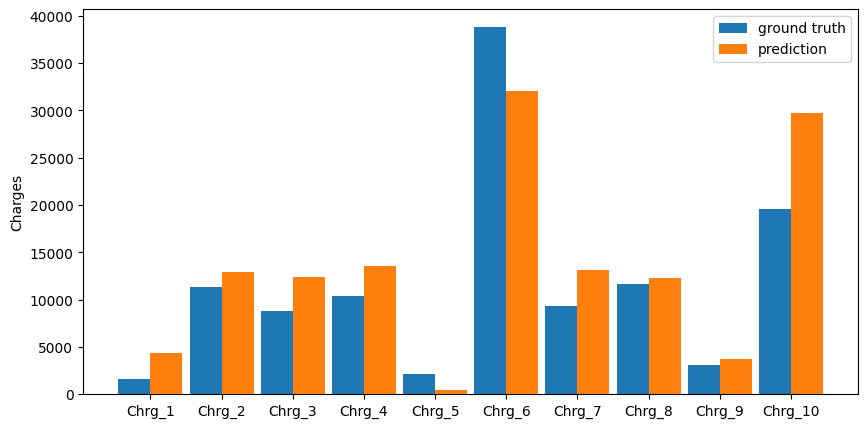

In [11]:
ytsPred = lrmm.predict(Xtsmm)

mae = mean_absolute_error(ytsPred,ytsmm)
mse = mean_squared_error(ytsPred,ytsmm)
rmse = np.sqrt(mse)

print('prediction for testing set:')
print('MAE is: {}'.format(mae))
print('MSE is: {}'.format(mse))
print('RMSE is: {}'.format(rmse))

# errors look quite similar... which is maybe good? Maybe its just outliers creating the big error.. but what is really strange to me is the fact that the numbers are so big.. the base dataset should be normalized and between 0 and 1 ... how do we produce such large errors? Maybe the linearRegression object is somehow de-normalizing my data? to give me numbers related to my original numbers? ... not sure, this mystery has got me confused but I will just move on for now. 

labels = ['Chrg_1','Chrg_2','Chrg_3','Chrg_4','Chrg_5','Chrg_6','Chrg_7','Chrg_8','Chrg_9','Chrg_10',]
x = np.arange(len(labels))  # the label locations
width = 0.45  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5)) # pylance AND general documentation for this don't have figsize as a parameter which can be adjusted.. wtf. How is one to learn about such features. 
rects1 = ax.bar(x - width/2, ytsmm[0:10], width, label='ground truth')
rects2 = ax.bar(x + width/2, ytsPred[0:10], width, label='prediction')

ax.set_ylabel('Charges')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show() # bars look good, and the model is not horrible looking either

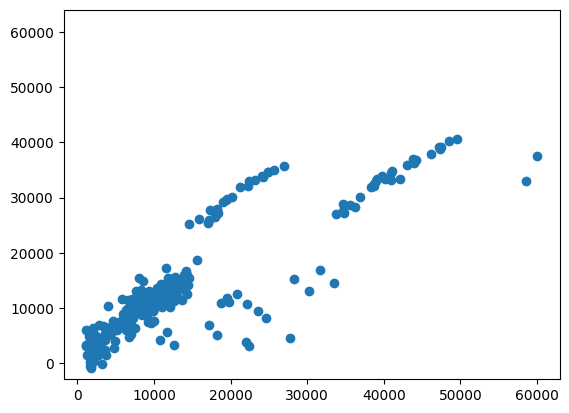

R^2: 0.7623224022563388


In [12]:
# making scatter plot to compare predicted values to ground truth values 

fig, ax = plt.subplots()
scatter = ax.scatter(ytsmm, ytsPred)
ax.set_ylim(top=64000) # this worked for manually setting the limits on the y axis 
plt.show()

# I would also like to see the R^2 value for this... obviously the model isn't so good. 
from sklearn.metrics import r2_score

r2 = r2_score(ytsmm, ytsPred)
print("R^2:", r2) #R^2: 0.7623224022563388 ... honestly that isn't as bad as I expected. But what does it really say about the data? 


## Ridge Regression


In [13]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import accuracy_score

regCoefficient = [.01, .05, .1, .25, .5, .75, 1, 2.5, 5, 7.5, 10] # 11 values to test

# Standardized Variables: Xtrain, Xtest, yTrain, yTest
# Standardized Variables untouched Binary values: XtrainBin, XtestBin, yTrainBin, yTestBin
# MinMax variables with Normalized Target: Xtrmm, Xtsmm, ytrmmScaled, ytsmmScaled
# MinMax variables non-Normalized Target: Xtrmm, Xtsmm, ytrmm, ytsmm

#print(Xtrain, Xtest, yTrain, yTest)
#print(XtrainBin, XtestBin, yTrainBin, yTestBin)
#print("\n\n\n", Xtrmm, Xtsmm, ytrmm, ytsmm)
#print("\n\n\n", Xtrmm, Xtsmm, ytrmmScaled, ytsmmScaled)

# this loop gets the best reg value, then we use that reg value to make predictions on the testing data. 
best_r2 = 0
best_tst_r2 = 0
best_reg = 0 


for reg in regCoefficient: 
    rr = Ridge(alpha=reg)
    rr.fit(Xtrain, yTrain)

    y_temp_pred = rr.predict(Xtrain)
    y_tst_pred = rr.predict(Xtest)

    # Bias = rr.intercept_
    # weight = rr.coef_

    mae = mean_absolute_error(y_temp_pred, yTrain)
    mse = mean_squared_error(y_temp_pred, yTrain)
    rmse = np.sqrt(mse)
    r2 = r2_score(yTrain, y_temp_pred)
    #acc = accuracy_score(yTrain, y_temp_pred) # cannot get accuracy score for continuous values.. so we shall decide based upon the r2 score I suppose? 

    maeTst = mean_absolute_error(y_tst_pred, yTest)
    mseTst = mean_squared_error(y_tst_pred, yTest)
    rmseTst = np.sqrt(mseTst)
    r2Tst = r2_score(yTest, y_tst_pred)

    print('\n\nPrediction for training set: from reg:', reg, "\n")
    print('MAE is: {}, and for the test prediction its: {}'.format(mae, maeTst))
    print('MSE is: {}, and for the test prediction its: {}'.format(mse, mseTst))
    print('RMSE is: {}, and for the test prediction its: {}'.format(rmse, rmseTst))
    print('r^2 is: {}, and for the test prediction its: {}'.format(r2, r2Tst))
    #print('Accuracy Score is: {}'.format(acc))

    if best_r2 < r2:
        best_r2 = r2
        best_tst_r2 = r2Tst
        best_reg = reg

print("\n\nBest r2, r2Tst and reg of all:\n", best_r2, best_tst_r2, best_reg)



Prediction for training set: from reg: 0.01 

MAE is: 0.08258109548271111, and for the test prediction its: 0.0803194123836998
MSE is: 0.014436963670914347, and for the test prediction its: 0.013912635173030591
RMSE is: 0.12015391658582897, and for the test prediction its: 0.11795183412321569
r^2 is: 0.7475615631272967, and for the test prediction its: 0.7623221201676417


Prediction for training set: from reg: 0.05 

MAE is: 0.08258202922383434, and for the test prediction its: 0.08032040093961991
MSE is: 0.014436963761514062, and for the test prediction its: 0.013912701295263959
RMSE is: 0.12015391696284422, and for the test prediction its: 0.11795211441624927
r^2 is: 0.7475615615431097, and for the test prediction its: 0.7623209905619241


Prediction for training set: from reg: 0.1 

MAE is: 0.08258319629690329, and for the test prediction its: 0.08032163652440139
MSE is: 0.01443696404460319, and for the test prediction its: 0.01391278411277741
RMSE is: 0.12015391814087124, and fo

In [14]:
# Defining function to improve testing efficiency: 

    # this function should take in preprocessed data and a parameter which determines which lin reg model to use
    # it should return a named list (if that exists in python, maybe just a 1 x n data Frame?) which reports on the relevant values from each model, 
    # those ouputs can be funneled into a data Frame, which can than be hit with a graphing function to visualize all of the results. 
    # after results visulization the best model should be evident, and I can discuss it breifly for the lab. 
    # hypothetically I could recycle and build out these methods in the future in order to make testing of linear models more efficient for novel data sets. Would be fun to build this out across the semester. 


def linRegTester(X_train, X_test, y_train, y_test, model = "lr"):
    pass

    model_stats = dict()

    if model == 'lr':
        lr = LinearRegression()
        lr.fit(X_train, y_train)

        y_temp_pred = lr.predict(X_train)
        y_tst_pred = lr.predict(X_test)

        mae = mean_absolute_error(y_temp_pred, y_train)
        mse = mean_squared_error(y_temp_pred, y_train)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_train, y_temp_pred)

        maeTst = mean_absolute_error(y_tst_pred, y_test)
        mseTst = mean_squared_error(y_tst_pred, y_test)
        rmseTst = np.sqrt(mseTst)
        r2Tst = r2_score(y_test, y_tst_pred)

        model_stats['mae'] = mae
        model_stats['mse'] = mse
        model_stats['rmse'] = rmse
        model_stats['r2'] = r2
        model_stats['maeTst'] = maeTst
        model_stats['mseTst'] = mseTst
        model_stats['rmseTst'] = rmseTst
        model_stats['r2Tst'] = r2Tst
        model_stats['best_r2'] = best_r2
        model_stats['best_tst_r2'] = best_tst_r2
        model_stats['best_reg'] = best_reg
    

    elif model == 'lasso':
        regCoefficient = [.01, .05, .1, .25, .5, .75, 1, 2.5, 5, 7.5, 10]
        best_r2 = 0
        best_tst_r2 = 0
        best_reg = 0
        mae = 0.0
        mse = 0.0
        rmse = 0.0
        maeTst = 0.0
        mseTst = 0.0
        rmseTst = 0.0

        for reg in regCoefficient: 
            rr = Lasso(alpha=reg)
            rr.fit(X_train, y_train)
            
            y_temp_pred = rr.predict(X_train)
            y_tst_pred = rr.predict(X_test)
            r2 = r2_score(y_train, y_temp_pred)
            r2Tst = r2_score(y_test, y_tst_pred)

            if best_r2 < r2:
                best_r2 = r2
                best_tst_r2 = r2Tst
                best_reg = reg
                mae = mean_absolute_error(y_temp_pred, y_train)
                mse = mean_squared_error(y_temp_pred, y_train)
                rmse = np.sqrt(mse)
                maeTst = mean_absolute_error(y_tst_pred, y_test)
                mseTst = mean_squared_error(y_tst_pred, y_test)
                rmseTst = np.sqrt(mseTst)

        model_stats['mae'] = mae
        model_stats['mse'] = mse
        model_stats['rmse'] = rmse
        model_stats['r2'] = r2
        model_stats['maeTst'] = maeTst
        model_stats['mseTst'] = mseTst
        model_stats['rmseTst'] = rmseTst
        model_stats['r2Tst'] = r2Tst
        model_stats['best_r2'] = None
        model_stats['best_tst_r2'] = None
        model_stats['best_reg'] = None


    elif model == 'rr':
        regCoefficient = [.01, .05, .1, .25, .5, .75, 1, 2.5, 5, 7.5, 10]
        best_r2 = 0
        best_tst_r2 = 0
        best_reg = 0
        mae = 0.0
        mse = 0.0
        rmse = 0.0
        maeTst = 0.0
        mseTst = 0.0
        rmseTst = 0.0

        for reg in regCoefficient: 
            rr = Ridge(alpha=reg)
            rr.fit(X_train, y_train)

            y_temp_pred = rr.predict(X_train)
            y_tst_pred = rr.predict(X_test)
            r2 = r2_score(y_train, y_temp_pred)
            r2Tst = r2_score(y_test, y_tst_pred)

            if best_r2 < r2:
                best_r2 = r2
                best_tst_r2 = r2Tst
                best_reg = reg
                mae = mean_absolute_error(y_temp_pred, y_train)
                mse = mean_squared_error(y_temp_pred, y_train)
                rmse = np.sqrt(mse)
                maeTst = mean_absolute_error(y_tst_pred, y_test)
                mseTst = mean_squared_error(y_tst_pred, y_test)
                rmseTst = np.sqrt(mseTst)

        model_stats['mae'] = mae
        model_stats['mse'] = mse
        model_stats['rmse'] = rmse
        model_stats['r2'] = r2
        model_stats['maeTst'] = maeTst
        model_stats['mseTst'] = mseTst
        model_stats['rmseTst'] = rmseTst
        model_stats['r2Tst'] = r2Tst
        model_stats['best_r2'] = None
        model_stats['best_tst_r2'] = None
        model_stats['best_reg'] = None


    data_in = [X_train, X_test, y_train, y_test]
    statsNdata = [data_in, model_stats]
    return statsNdata

#TODO: Test this function, then run it on the variations you want to run it on, after getting exported list of lists.. or w/e DS you store the returns in fokin graph that shit and then make up your report and submit it. 

## Ridge Regression Outcomes: 

on the training data AND the test data there is no significant difference for changeing the reg value at all with respect to the r2 produced. All r2's were practically identical at 74% . 

- Best r2 and reg of all:
 - 0.7475615631272967 0.01

Similarly the MAE MSE and RMSE were all practically identical as well.

### Comparison Notes: 

I need to compare several different intersections of preprocessing techniques and models to draw insight from my work. Gonna list the intersections here: 

Preprocessing Techniques: 
1. Standardization, 
2. Standardization with Binary values untouched, 
3. MinMax normalization 
4. Min Max normalization with non-normalized target var. (ytrmm, ytsmm)

Regression Models (techniques):
1. Linear Regression
2. Ridge Regression
3. Lasso Regression 

3 x 4 = 12 => 12 different prediction sets to compare against one another. 

**IMPORTANTLY** We need to see how the model does on the training data versus the testing data. So we actually have 2x the reporting statistics to make up per intersection (I think)

For 8 of the 12 we will be picking the best regularization coefficient and reporting it along side the prediction accuracy. (8 because there is no reg coefficient in the Linear Regression)

Finally it would be nice to see all of these in a table and maybe put them into a simple bar graph which represents any key values which communicate about the efficacy of each model. 
